In [303]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score
from datetime import datetime, timedelta
from dateutil.relativedelta import *


def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

def line_of_best_fit(X, Y): 
    """
    finds the line of best fit of two arrays using the (XtX)^-1Xty equation
    
    Args:
        x (array): either 1-d or 2-d
        y (array): 1-d
    
    Return:
        m (array): vector including intercept(first num) and slope(second num) for line of best fit
    
    """
    
    X_into_array = add_bias_column(X)
    XtXinv = np.linalg.inv(np.matmul(X_into_array.T, X_into_array))
    m = np.matmul(XtXinv, np.matmul(X_into_array.T, Y))
    
    return m

def linreg_predict(Xnew, ynew, m):
    """
    Predicts the linear regression and gives it a score on how well the variance is explained
    Args: 
        Xnew (array): either 1-d or 2-d, includes all p predictor features
        ynew (array): 1-d array, includes all correspondign response values to Xnew
        m (array): array that shows the intercept and the slope to be used for calculating ypreds
        
    Returns:
        dictionary (dict): four key-value pairs (ypreds, resids, mse, r2)
    
    """
    Xnew = add_bias_column(Xnew)
    ypreds = np.matmul(Xnew, m)
    resids = ynew - ypreds
    mse = (resids**2).sum()/resids.size
    r2 = r2_score(ynew, ypreds)
    
    dictionary = {'ypreds': ypreds,
                  'resids':resids,
                  'mse':mse,
                  'r2':r2
                 }
    return dictionary


In [300]:
def generate_dates(start_date, end_date, month_period=1, week_period=0, day_period=0):
    """
    Generate a list of dates from start_date to end_date with increments of time_period days.
    
    Parameters:
    start_date (str): The start date in 'YYYY-MM-DD' format.
    end_date (str): The end date in 'YYYY-MM-DD' format.
    time_period (int): The number of days for each time period.
    
    Returns:
    list: A list of dates in 'YYYY-MM-DD' format.
    """
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Initialize list of dates
    date_list = []
    
    # Generate dates in the specified range
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += relativedelta(months=+month_period)
        current_date += timedelta(weeks = week_period)
        current_date += timedelta(days = day_period)
    
    return date_list

# Function to get data from a single page
def get_data_from_page(page_num, start_date, end_date):
    url = f'https://bff.capitoltrades.com/trades?per_page=96&page={page_num}&pageSize=96&txDate={start_date},{end_date}'
    response = requests.get(url)
    return json.loads(response.text)

def create_volume_df(dates):  
    volumes = []
    for i in range(len(dates) - 1):
        volume_sum = 0
        page_num = 1
        while True:
            data = get_data_from_page(page_num, dates[i], dates[i+1])
            if not data['data']:
                break
            volume_sum += sum([trade['value'] for trade in data['data'] if trade['value'] is not None and trade['txType'] == 'buy'])
            page_num += 1
        volumes.append([datetime.strptime(dates[i],'%Y-%m-%d'), volume_sum])
        #volumes.append([dates[i], volume_sum])
    return pd.DataFrame(volumes)


In [301]:
def graph_volume(start_date, end_date, month_period=1, week_period=0, day_period=0):
    """
    Graphs the volume of stocks being bought
    """
    
    dates = generate_dates(start_date, end_date, month_period, week_period, day_period)
    
    volume_df = create_volume_df(dates)
    
    X = np.array(list(range(1, len(volume_df) + 1)))
    Y = np.array(volume_df[1])
    equation = line_of_best_fit(X, Y)
    predict = linreg_predict(X, Y, equation)
    
    plt.figure(figsize=(10, 8))
    plt.plot(volume_df[0], volume_df[1], label='Volume', linewidth=3, marker='x', markersize=20, markeredgewidth=4, markeredgecolor='green')
    plt.plot(volume_df[0], predict['ypreds'], color='red', label='Linear Regression')
    plt.xlabel('Dates')
    plt.ylabel('Total Volume')
    plt.xticks(rotation = 45)
    plt.title('Dates vs Total Volume with Linear Regression')
    plt.legend()
    print(predict)
    


{'ypreds': array([  466955.99999999,  4260525.19999999,  8054094.39999999,
       11847663.59999999, 15641232.79999999, 19434801.99999999]), 'resids': array([ 3344044.00000001,  -806746.19999999,  1745405.60000001,
       -4917924.59999999, -8893602.79999999,  9528824.00000001]), 'mse': 34826758395348.473, 'r2': 0.5465324659620157}


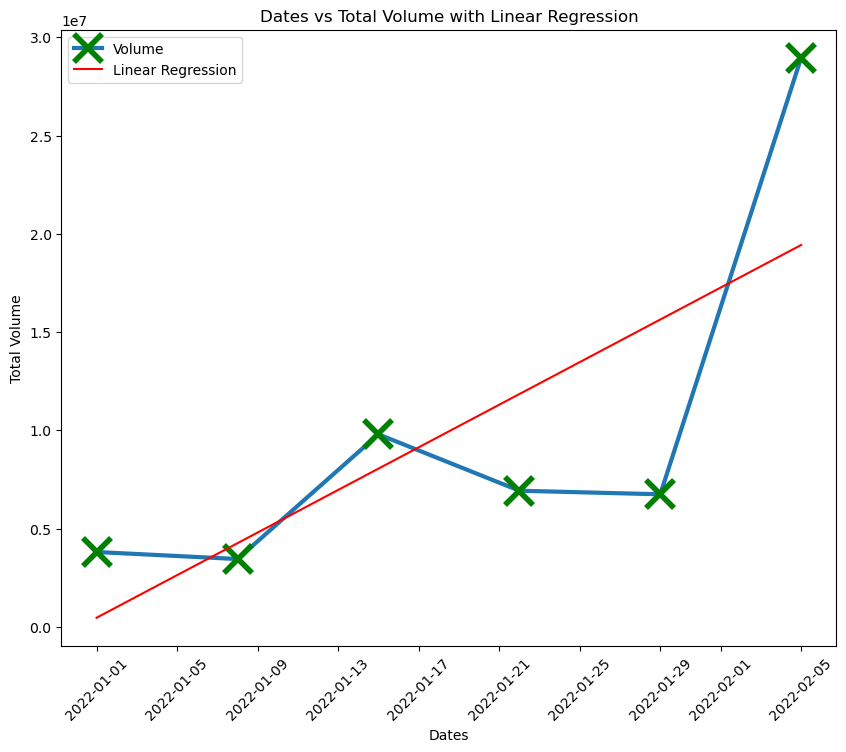

In [305]:
start_date = '2022-01-01'
end_date = '2022-02-14'
month_period = 0
week_period = 1
day_period = 0
graph_volume(start_date, end_date, month_period, week_period, day_period)

Explore and Transfer one ML model to a Python Script (out
of Jupyter NB format)
- Transfer model training/testing cleaned data into the database
- Fully explore the first ML model (checking assumptions, model
validation...) via Jupyter
- Convert NB code into pure Python Script. Separate into
training/testing functions and inference functions
- Where possible, train once and store the appropriate model
weights/values in the database and use those for future prediction
instead of retraining every time a call is made

In [ ]:
# Checking Assumptions




